In [1]:
import torch
import numpy as np
from torch.autograd import Variable
from torch.distributions import Normal


class tOU:
    def __init__(self, t0, t1, alpha, beta, r, sde_sigma, init_dist, timegrid=False, dN=500):
        """
            t0, t1 = torch.tensor(t1)
            alpha, beta, m0, r, sigma = torch.tensor.shape (D, 1)
        """
        assert alpha.shape == beta.shape == r.shape == sde_sigma.shape, "parameters must have the same dimension"
        assert alpha.shape[1] == 1, "parameter must have a shape D*1"
        assert all(sigma > 0), "variance must be positive"
        assert all(r > 0), "r must be positive"
        
        self.t0 = t0
        self.t1 = t1
        self.alpha = alpha
        self.beta = beta
        self.sigma = sde_sigma
        self.r = r
        D = alpha.shape[0]
        
        if timegrid == True:
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
            
        self.trj, self.dt = self.path(init_dist)
        
            
    def path(self, init_dist):
        """
            init_dist: distribution to draw an initial state
            init_dist = Normal(loc=E[X_{t_{i-1}}|lambda_{i-1}], scale = std[X_{t_{i-1}}|lambda_{i-1}])
        """
        
        # Get parameters
        alpha = self.alpha
        beta = self.beta
        sigma = self.sigma
        r = self.r
        t = self.pts
    
        def mean(x, dt, t0, alpha, beta, m0, r):
            """
                t0: we always start our process from t = 0
            """

            b_t = alpha * ( (t0[:,0].reshape(-1, 1) + 1) ** beta  - 1) + m0 - (alpha  * ((t0[:, 1].reshape(-1, 1) + 1) ** beta - 1) + m0 ) * torch.exp(r * dt.reshape(-1, 1))
            return (x.reshape(-1, 1) - b_t) * torch.exp(-r * dt.reshape(-1, 1))

        def std(t, r, sigma):
            return torch.sqrt(variance(t, r, sigma))

        def variance(t, r, sigma):
            dt = torch.diff(t)
            return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)
        
        normal = Normal(loc=0., scale=1.)
        x = normal.sample(t.size())

        if type(init_dist) == torch.distributions.normal.Normal:
            # sample initial state from approximate posterior distribution
            m0 = init_dist.sample([x.shape[0], 1])
            x[:, 0] = m0.flatten()
        else:
            m0 = init_dist
            x[:, 0] = m0.flatten()
            
        t0 = t - t[:, 0].reshape(-1, 1)

        dt = torch.diff(t)

        scale = std(t, r.reshape(-1,1), sigma.reshape(-1, 1))

        x[:, 1:] = x[:, 1:] * scale
        for i in range(1, x.shape[1]):
            x[:, i] += mean(x[:, i-1], dt[:, i-1], t0[:, i-1:i+1], alpha, beta, m0, r).flatten()


        return x, dt


In [2]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(0.)
t1 = torch.tensor(1.)

In [3]:
alpha = torch.tensor([1., 1.]).reshape(-1, 1)
beta = torch.tensor([1., 1.]).reshape(-1, 1)
r = torch.tensor([1., 1.]).reshape(-1, 1)
sigma = torch.tensor([1., 1.]).reshape(-1, 1)

In [4]:
tou = tOU(t0, t1, alpha, beta, r, sigma, init_dist=dist)

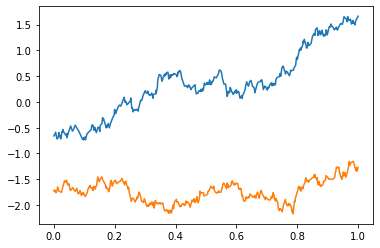

In [5]:
import matplotlib.pylab as plt

plt.plot(tou.pts.T, tou.trj.T)

In [6]:
def tou_gradient(t, x, params, sde_sigma, init_dist):
    assert torch.is_tensor(sde_sigma), "sde_sigma must be a (D*1) tensor"
    assert torch.is_tensor(init_dist) or type(init_dist) == torch.distributions.normal.Normal,\
    "init_dist must either be tensor or torch.distributions"
    
    """
        Calculates log likelihood of a path
        Note that there are three parameters, alpha, beta, r
    """
    
    def mean(x, t, alpha, beta, m0, r):
        """
            t0: we always start our process from t = 0
        """
        t0 = t - t[:, 0].reshape(-1, 1)
        dt = torch.diff(t)
        m_t = alpha * ( (t0[:, :-1] + 1) ** beta  - 1) + m0 - (alpha * ((t0[:, 1:] + 1) ** beta - 1 ) + m0) * torch.exp(r * dt)

        return (x - m_t) * torch.exp(-r * dt)
    
    def std(t, r, sigma):
        return torch.sqrt(variance(t, r, sigma))

    def variance(t, r, sigma):
        dt = torch.diff(t)
        return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)

    params_ = Variable(params, requires_grad=True)
    alpha, beta, r, = params_
    sigma = sde_sigma

    m0 = x[:, 0].reshape(-1, 1)
    mu = mean(x[:, :-1], t, alpha, beta, m0, r)
    var = std(t, r, sigma) + 1e-7 # To prevent the underflow (some of the value becomes 0 due to lack of precision
    LL = torch.sum(Normal(loc=mu, scale=var).log_prob(x[:, 1:]), axis=1)

    # At initialization (in case of random initialization)
    if type(init_dist) == torch.distributions.normal.Normal:
        LL += torch.sum(init_dist.log_prob(x[:,0]))
    
    LL.backward(torch.tensor([1.]).repeat(x.shape[0]))
    
    return {'alpha':params_.grad[0].clone().detach(), 'beta':params_.grad[1].clone().detach(), 
            'r':params_.grad[2].clone().detach(), 'LL':LL.clone().detach().data}



In [7]:
tou_gradient(tou.pts, tou.trj, torch.stack([alpha, beta, r]), sigma, dist)

{'alpha': tensor([[ 2.9842],
         [-1.4219]]),
 'beta': tensor([[ 4.2056],
         [-1.7869]]),
 'r': tensor([[-0.7822],
         [-0.0107]]),
 'LL': tensor([922.8107, 952.6277])}